
# Compute source space connectivity and visualize it using a circular graph

This example computes the all-to-all connectivity between 68 regions in
source space based on dSPM inverse solutions and a FreeSurfer cortical
parcellation. The connectivity is visualized using a circular graph which
is ordered based on the locations of the regions in the axial plane.


In [3]:
# Authors: Martin Luessi <mluessi@nmr.mgh.harvard.edu>
#          Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Nicolas P. Rougier (graph code borrowed from his matplotlib gallery)
#
# License: BSD (3-clause)

import matplotlib.pyplot as plt
import mne
import numpy as np
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.viz import circular_layout

from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle

print(__doc__)

Automatically created module for IPython interactive environment


## Load our data

First we'll load the data we'll use in connectivity estimation. We'll use
the sample MEG data provided with MNE.



In [4]:
data_path = sample.data_path()
subjects_dir = data_path / "subjects"
fname_inv = data_path / "MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif"
fname_raw = data_path / "MEG/sample/sample_audvis_filt-0-40_raw.fif"
fname_event = data_path / "MEG/sample/sample_audvis_filt-0-40_raw-eve.fif"

# Load data
inverse_operator = read_inverse_operator(fname_inv)
raw = mne.io.read_raw_fif(fname_raw)
events = mne.read_events(fname_event)

# Add a bad channel
raw.info["bads"] += ["MEG 2443"]

# Pick MEG channels
picks = mne.pick_types(
    raw.info, meg=True, eeg=False, stim=False, eog=True, exclude="bads"
)

# Define epochs for left-auditory condition
event_id, tmin, tmax = 1, -0.2, 0.5
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    picks=picks,
    baseline=(None, 0),
    reject=dict(mag=4e-12, grad=4000e-13, eog=150e-6),
)

Using default location ~/mne_data for sample...
Creating C:\Users\tamay\mne_data


100%|#############################################| 1.65G/1.65G [00:00<?, ?B/s]
Untarring contents of 'C:\Users\tamay\mne_data\MNE-sample-data-processed.tar.gz' to 'C:\Users\tamay\mne_data'


Attempting to create new mne-python configuration file:
C:\Users\tamay\.mne\mne-python.json
Download complete in 02m34s (1576.2 MB)
Reading inverse operator decomposition from C:\Users\tamay\mne_data\MNE-sample-data\MEG\sample\sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch st

## Compute inverse solutions and their connectivity

Next, we need to compute the inverse solution for this data. This will return
the sources / source activity that we'll use in computing connectivity. We'll
compute the connectivity in the alpha band of these sources. We can specify
particular frequencies to include in the connectivity with the ``fmin`` and
``fmax`` flags. Notice from the status messages how mne-python:

1. reads an epoch from the raw file
2. applies SSP and baseline correction
3. computes the inverse to obtain a source estimate
4. averages the source estimate to obtain a time series for each label
5. includes the label time series in the connectivity computation
6. moves to the next epoch.

This behaviour is because we are using generators. Since we only need to
operate on the data one epoch at a time, using a generator allows us to
compute connectivity in a computationally efficient manner where the amount
of memory (RAM) needed is independent from the number of epochs.



In [5]:
# Compute inverse solution and for each epoch. By using "return_generator=True"
# stcs will be a generator object instead of a list.
snr = 1.0  # use lower SNR for single epochs
lambda2 = 1.0 / snr**2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)
stcs = apply_inverse_epochs(
    epochs, inverse_operator, lambda2, method, pick_ori="normal", return_generator=True
)

# Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
labels = mne.read_labels_from_annot("sample", parc="aparc", subjects_dir=subjects_dir)
label_colors = [label.color for label in labels]

# Average the source estimates within each label using sign-flips to reduce
# signal cancellations, also here we return a generator
src = inverse_operator["src"]
label_ts = mne.extract_label_time_course(
    stcs, labels, src, mode="mean_flip", return_generator=True
)

fmin = 8.0
fmax = 13.0
sfreq = raw.info["sfreq"]  # the sampling frequency
con_methods = ["pli", "wpli2_debiased", "ciplv"]
con = spectral_connectivity_epochs(
    label_ts,
    method=con_methods,
    mode="multitaper",
    sfreq=sfreq,
    fmin=fmin,
    fmax=fmax,
    faverage=True,
    mt_adaptive=True,
    n_jobs=1,
)

# con is a 3D array, get the connectivity for the first (and only) freq. band
# for each method
con_res = dict()
for method, c in zip(con_methods, con):
    con_res[method] = c.get_data(output="dense")[:, :, 0]

Reading labels from parcellation...
   read 34 labels from C:\Users\tamay\mne_data\MNE-sample-data\subjects\sample\label\lh.aparc.annot
   read 34 labels from C:\Users\tamay\mne_data\MNE-sample-data\subjects\sample\label\rh.aparc.annot
Connectivity computation...
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 305 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 72 (at most)
Extracting time courses for 68 labels (mode: mean_flip)
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..0.699s for estimation (106 points)
    frequencies: 8.5Hz..12.7Hz (4 points)
 

## Make a connectivity plot

Now, we visualize this connectivity using a circular graph layout.



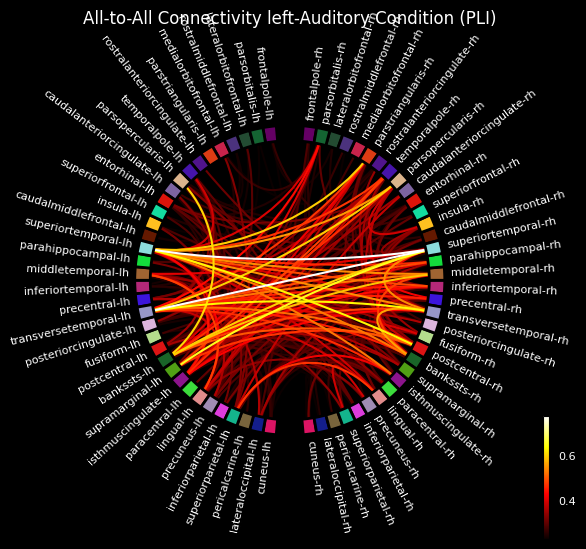

In [6]:
# First, we reorder the labels based on their location in the left hemi
label_names = [label.name for label in labels]

lh_labels = [name for name in label_names if name.endswith("lh")]

# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + "rh" for label in lh_labels]

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = circular_layout(
    label_names, node_order, start_pos=90, group_boundaries=[0, len(label_names) / 2]
)

# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
fig, ax = plt.subplots(figsize=(8, 8), facecolor="black", subplot_kw=dict(polar=True))
plot_connectivity_circle(
    con_res["pli"],
    label_names,
    n_lines=300,
    node_angles=node_angles,
    node_colors=label_colors,
    title="All-to-All Connectivity left-Auditory " "Condition (PLI)",
    ax=ax,
)
fig.tight_layout()

## Make multiple connectivity plots in the same figure

We can also assign these connectivity plots to axes in a figure. Below we'll
show the connectivity plot using two different connectivity methods.



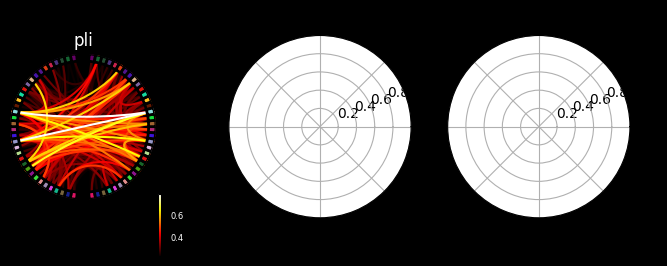

In [7]:
fig, axes = plt.subplots(
    1, 3, figsize=(8, 4), facecolor="black", subplot_kw=dict(polar=True)
)
no_names = [""] * len(label_names)
for ax, method in zip(axes, con_methods):
    plot_connectivity_circle(
        con_res[method],
        no_names,
        n_lines=300,
        node_angles=node_angles,
        node_colors=label_colors,
        title=method,
        padding=0,
        fontsize_colorbar=6,
        ax=ax,
    )

## Save the figure (optional)

By default matplotlib does not save using the facecolor, even though this was
set when the figure was generated. If not set via savefig, the labels, title,
and legend will be cut off from the output png file.

```python
import os.path as op
fname_fig = op.join(data_path, 'MEG', 'sample',
                    'plot_inverse_connect.png')
fig.savefig(fname_fig, facecolor=fig.get_facecolor())
```
